In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
# Read hyperopt data
lines_start = 4135
lines_end = -1
df = pd.read_csv("../results/hyperopt.csv").iloc[lines_start:lines_end]

# Baseline
df_baseline = pd.read_csv("../results/data.csv")
df_baseline["adapter"] = df_baseline["adapter"].fillna("no_adapter")

df.head(5)

,dataset,model,adapter,n_features,n_components,context_length,forecasting_horizon,num_layers,hidden_dim,learning_rate,...,mae,test_mse,test_mae,num_coupling,scaled_mse,scaled_mae,test_scaled_mse,test_scaled_mae,use_revin,beta
4135,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,128.0,0.001,...,0.895420,4.631161,1.439878,2.0,1.417450,0.915557,4.559346,1.443506,False,NaN
4136,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,256.0,0.001,...,0.788260,5.106150,1.563980,1.0,1.107222,0.806023,5.091413,1.574175,False,NaN
4137,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,64.0,0.001,...,0.862974,5.582616,1.665431,3.0,1.318521,0.878625,5.598715,1.679468,True,NaN
4138,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,128.0,0.001,...,0.928119,5.642131,1.699702,2.0,1.431926,0.945989,5.626446,1.710713,True,NaN
4139,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,128.0,0.001,...,0.915661,5.623275,1.773968,2.0,1.459336,0.937202,5.634658,1.787329,True,NaN


In [3]:
forecasting_horizon = 24
dataset_name = "Illness" + f"_pred={forecasting_horizon}"
model_name = "AutonLab/MOMENT-1-small"
adapter = "flow"
n_components = 7
hypers = [
    "hidden_dim",
    # "learning_rate",
    # "batch_size",
    "num_coupling",
    # "num_layers",
    "use_revin",
    # "beta", 
]

df_sub = df[
    (df["dataset"] == dataset_name)
    & (df["model"] == model_name)
    & (df["adapter"] == adapter)
    & (df["n_components"] == n_components)
]
df_baseline_sub = df_baseline[
    (df_baseline["dataset"] == dataset_name.split("_")[0])
    & (df_baseline["foundational_model"] == model_name)
    & (df_baseline["is_fine_tuned"].isin(["False"]))
    & (df_baseline["adapter"] == "no_adapter")
]

df_sub.head(5)

,dataset,model,adapter,n_features,n_components,context_length,forecasting_horizon,num_layers,hidden_dim,learning_rate,...,mae,test_mse,test_mae,num_coupling,scaled_mse,scaled_mae,test_scaled_mse,test_scaled_mae,use_revin,beta
4135,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,128.0,0.001,...,0.895420,4.631161,1.439878,2.0,1.417450,0.915557,4.559346,1.443506,False,NaN
4136,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,256.0,0.001,...,0.788260,5.106150,1.563980,1.0,1.107222,0.806023,5.091413,1.574175,False,NaN
4137,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,64.0,0.001,...,0.862974,5.582616,1.665431,3.0,1.318521,0.878625,5.598715,1.679468,True,NaN
4138,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,128.0,0.001,...,0.928119,5.642131,1.699702,2.0,1.431926,0.945989,5.626446,1.710713,True,NaN
4139,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,128.0,0.001,...,0.915661,5.623275,1.773968,2.0,1.459336,0.937202,5.634658,1.787329,True,NaN


In [4]:
df_baseline_clean = df_baseline_sub.drop(
    columns=[
        "dataset",
        "foundational_model",
        "adapter",
        "n_features",
        "forecasting_horizon",
        "n_components",
        "context_length",
        "is_fine_tuned",
    ],
    inplace=False,
)
df_clean = df_sub.drop(
    columns=[
        "dataset",
        "model",
        "adapter",
        "n_features",
        "forecasting_horizon",
        "n_components",
        "context_length",
    ],
    inplace=False,
)
df_clean = df_clean.loc[:, df_clean.nunique() != 1]
df_clean = df_clean.dropna(axis=1, how="all")
df_clean = df_clean.loc[:, ~df_clean.columns.str.contains("scaled")]
df_clean = df_clean.dropna()
df_clean.head(5)

,hidden_dim,running_time,mse,mae,test_mse,test_mae,num_coupling,use_revin
4135,128.0,133.247162,1.361973,0.895420,4.631161,1.439878,2.0,False
4136,256.0,130.421505,1.058288,0.788260,5.106150,1.563980,1.0,False
4137,64.0,232.094925,1.283331,0.862974,5.582616,1.665431,3.0,True
4138,128.0,244.382933,1.383780,0.928119,5.642131,1.699702,2.0,True
4139,128.0,364.188353,1.393750,0.915661,5.623275,1.773968,2.0,True


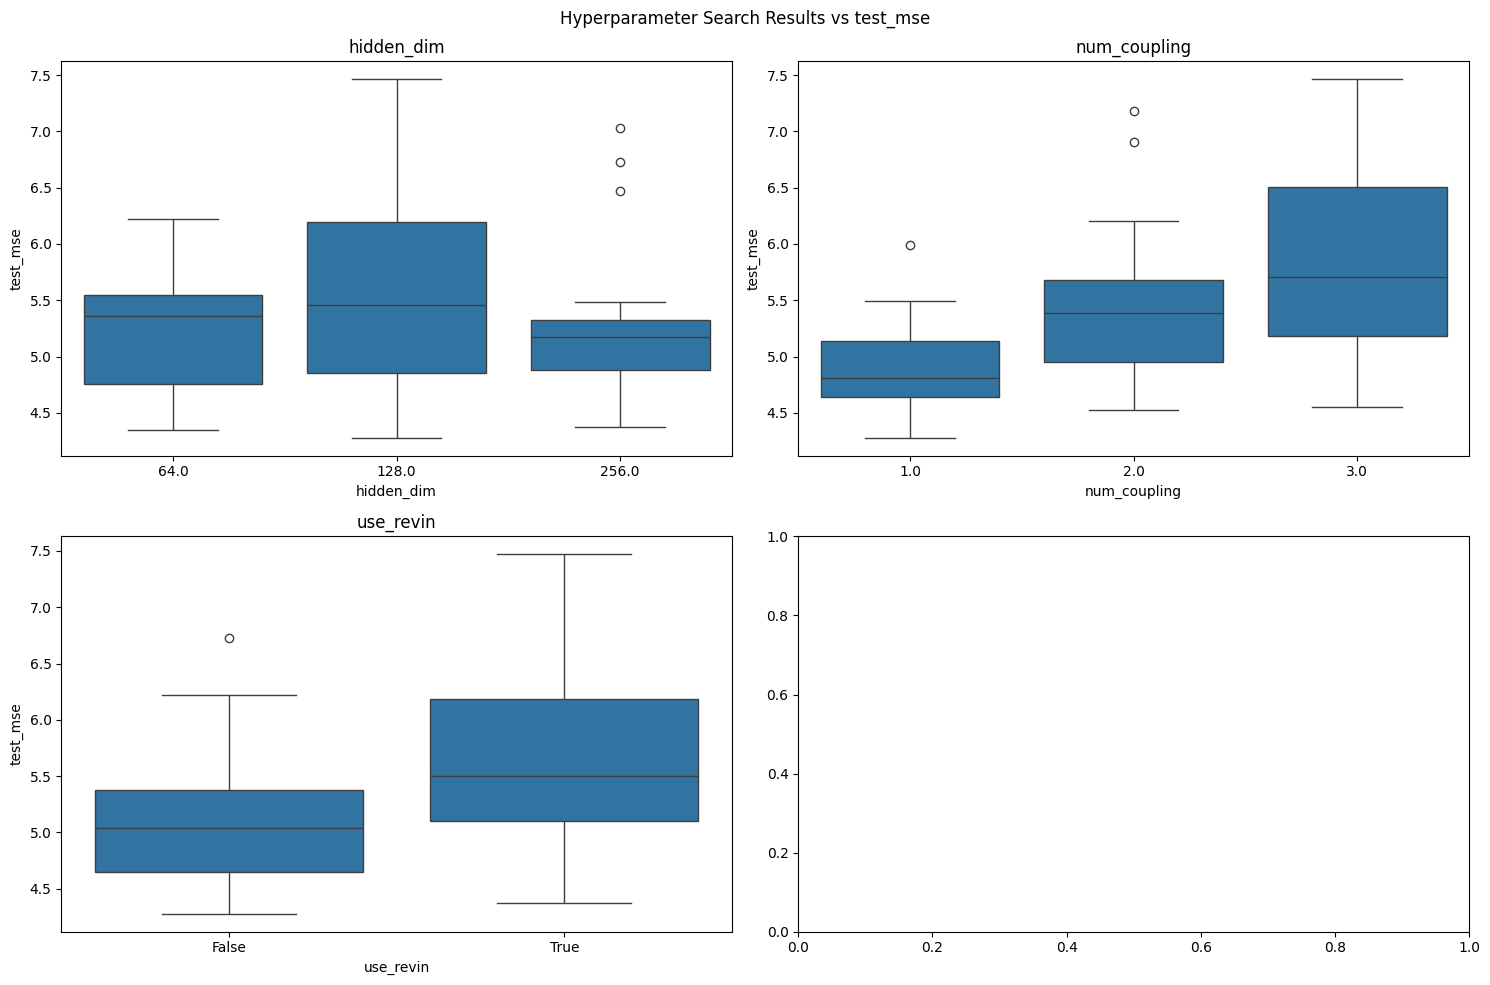

In [5]:
metric = "test_mse"

# Create subplots for each hyperparameter
fig, axes = plt.subplots(len(hypers) // 2 + len(hypers) % 2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.suptitle(f"Hyperparameter Search Results vs {metric}")

for i, hyper in enumerate(hypers):
    if hyper in df_clean.columns:
        sns.boxplot(data=df_clean, x=hyper, y=metric, ax=axes[i])
    axes[i].set_title(hyper)

plt.tight_layout()
plt.show()

In [6]:
# Group by the hyperparameters and calculate mean and std for each metric
grouped_df = df_clean.groupby(hypers).agg(["mean", "std", "count"])

# Flatten the MultiIndex columns
grouped_df.columns = ["_".join(col).strip() for col in grouped_df.columns.values]

grouped_df.reset_index(inplace=True)

posx and posy should be finite values
posx and posy should be finite values


[metric: mse]
hidden_dim      256.0
num_coupling      1.0
use_revin       False
Name: 12, dtype: object
 5.106150261640194+-nan  
---

[metric: mae]
hidden_dim      256.0
num_coupling      1.0
use_revin       False
Name: 12, dtype: object
 5.106150261640194+-nan  
---

[metric: test_mse]
hidden_dim      256.0
num_coupling      1.0
use_revin        True
Name: 13, dtype: object
 4.796181682712015+-0.14737754394153382  
---

baseline(test_mse): 5.155986272556038 +- 0.025527765831648203
[metric: test_mae]
hidden_dim       64.0
num_coupling      1.0
use_revin       False
Name: 0, dtype: object
 4.803813952064958+-0.2436683778079666  
---

baseline(test_mae): 1.6057570903378418 +- 0.0026126972018718645


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


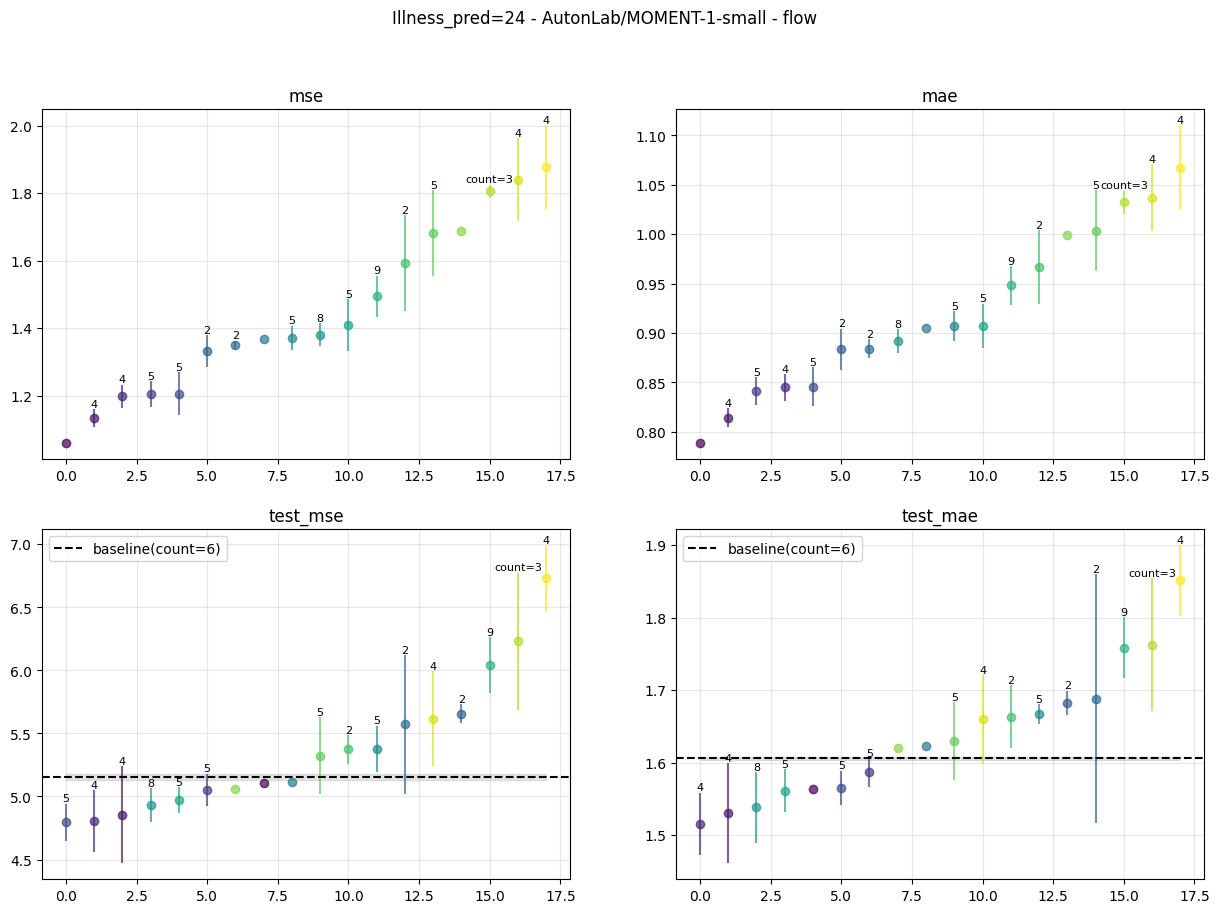

In [7]:
top_k = 50
metrics = ["mse", "mae", "test_mse", "test_mae"]
fig, axes = plt.subplots(len(metrics) // 2, 2, figsize=(15, 10))
fig.suptitle(f"{dataset_name} - {model_name} - {adapter}")
axes = axes.flatten()

# Create a color map based on initial rankings for mse
num_configs = len(grouped_df)
colors = plt.cm.viridis(np.linspace(0, 1, num_configs))

# Get initial ranking order based on mse
initial_order = grouped_df.sort_values(by="mse_mean").index
color_dict = dict(zip(initial_order, colors))

for i, metric in enumerate(metrics):
    # Sort by the specified metric mean
    sorted_df = grouped_df.sort_values(by=f"{metric}_mean", ascending=True)
    # Keep only top 12 configurations
    sorted_df = sorted_df.head(top_k)

    print(
        f"[metric: {metric}]\n{sorted_df.iloc[0][hypers]}\n {sorted_df.iloc[0]['test_mse_mean']}+-{sorted_df.iloc[0]['test_mse_std'] / np.sqrt(sorted_df.iloc[0]['test_mse_count'])}  \n---\n"
    )

    # Plot points with error bars using consistent colors
    size = len(sorted_df)
    for idx, row in sorted_df.iterrows():
        axes[i].errorbar(
            x=sorted_df.index.get_loc(idx),
            y=row[f"{metric}_mean"],
            yerr=row[f"{metric}_std"] / np.sqrt(row[f"{metric}_count"]),
            fmt="o",
            color=color_dict[idx],
            alpha=0.7,
        )
        ct = int(row[f"{metric}_count"])
        axes[i].text(
            sorted_df.index.get_loc(idx),
            row[f"{metric}_mean"]
            + row[f"{metric}_std"] / np.sqrt(row[f"{metric}_count"]),
            f"count={ct}" if idx == size - 1 else str(ct),
            fontsize=8,
            ha="center",
            va="bottom",
        )

    # baseline
    if "test" in metric:
        values = df_baseline_clean.loc[df_baseline_clean["metric"] == metric[5:]][
            "value"
        ]
        baseline = values.mean()
        baseline_std = values.std()
        print(
            f"baseline({metric}): {baseline} +- {baseline_std / np.sqrt(len(values))}"
        )
        x_range = [0, len(sorted_df) - 1]
        axes[i].axhline(
            y=baseline,
            color="black",
            linestyle="--",
            label=f"baseline(count={len(values)})",
        )
        axes[i].fill_between(
            x_range,
            [baseline - baseline_std / np.sqrt(len(values))],
            [baseline + baseline_std / np.sqrt(len(values))],
            color="black",
            alpha=0.1,
        )
        axes[i].legend()

    axes[i].set_title(metric)
    axes[i].grid(True, alpha=0.3)
plt.show()